<a href="https://colab.research.google.com/github/hannesstuehrenberg/Probabilistic-Machine-Learning_lecture-PROJECTS/blob/main/projects/08-1SHXXXX_football_analytics/notebooks/data_loading_and_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 2. Data Loading and Exploration

- Code to load data
- Basic exploration (plots, statistics, missing data, etc.)

In [79]:
#mplsoccer is a Python library for plotting football charts in Matplotlib and loading StatsBomb open-data
!pip install mplsoccer
#Squarify is a Python library used to create treemap visualizations
!pip install squarify

In [14]:
#Import necessary libraries
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
from mplsoccer import VerticalPitch
from mplsoccer import Sbopen
import squarify

#Ignore warnings
import warnings
warnings.filterwarnings('ignore')

#Initialize parser
parser = Sbopen()

In [5]:
#First I want to get an overview of the available matches in my data. Statsbomb provides the data via an API. Competition data can be accessed like this:

df_competition = parser.competition()
df_competition.info()
df_competition.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74 entries, 0 to 73
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   competition_id             74 non-null     int64 
 1   season_id                  74 non-null     int64 
 2   country_name               74 non-null     object
 3   competition_name           74 non-null     object
 4   competition_gender         74 non-null     object
 5   competition_youth          74 non-null     bool  
 6   competition_international  74 non-null     bool  
 7   season_name                74 non-null     object
 8   match_updated              74 non-null     object
 9   match_updated_360          56 non-null     object
 10  match_available_360        10 non-null     object
 11  match_available            74 non-null     object
dtypes: bool(2), int64(2), object(8)
memory usage: 6.1+ KB


,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676
1,9,27,Germany,1. Bundesliga,male,False,False,2015/2016,2024-05-19T11:11:14.192381,None,None,2024-05-19T11:11:14.192381
2,1267,107,Africa,African Cup of Nations,male,False,True,2023,2024-06-13T07:51:02.452825,None,None,2024-06-13T07:51:02.452825
3,16,4,Europe,Champions League,male,False,False,2018/2019,2024-06-12T07:44:38.559714,2021-06-13T16:17:31.694,None,2024-06-12T07:44:38.559714
4,16,1,Europe,Champions League,male,False,False,2017/2018,2024-02-13T02:35:28.134882,2021-06-13T16:17:31.694,None,2024-02-13T02:35:28.134882


In [11]:
#This loads all matches across competitions and seasons available using the competition and the match interface of the API

all_matches = pd.DataFrame()
df_competition = parser.competition()

for _, row in df_competition.iterrows():
    try:
        matches = parser.match(row['competition_id'], row['season_id'])
        all_matches = pd.concat([all_matches, matches], ignore_index=True)
    except:
        continue

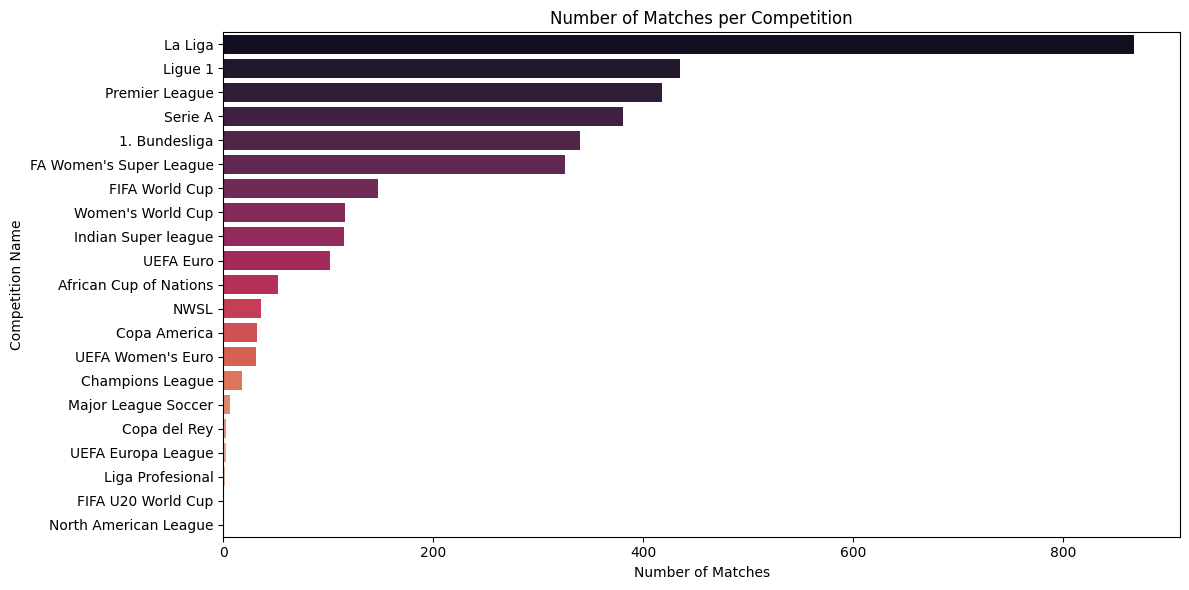

In [15]:
#First I want to understand how many matches are available per competition. Therefore, a simple bar chart is created.

match_counts = all_matches.groupby('competition_name').size().sort_values(ascending=False)

plt.figure(figsize=(12, 6))
sns.barplot(x=match_counts.values, y=match_counts.index, palette="rocket")

plt.title('Number of Matches per Competition')
plt.xlabel('Number of Matches')
plt.ylabel('Competition Name')
plt.tight_layout()
plt.show()

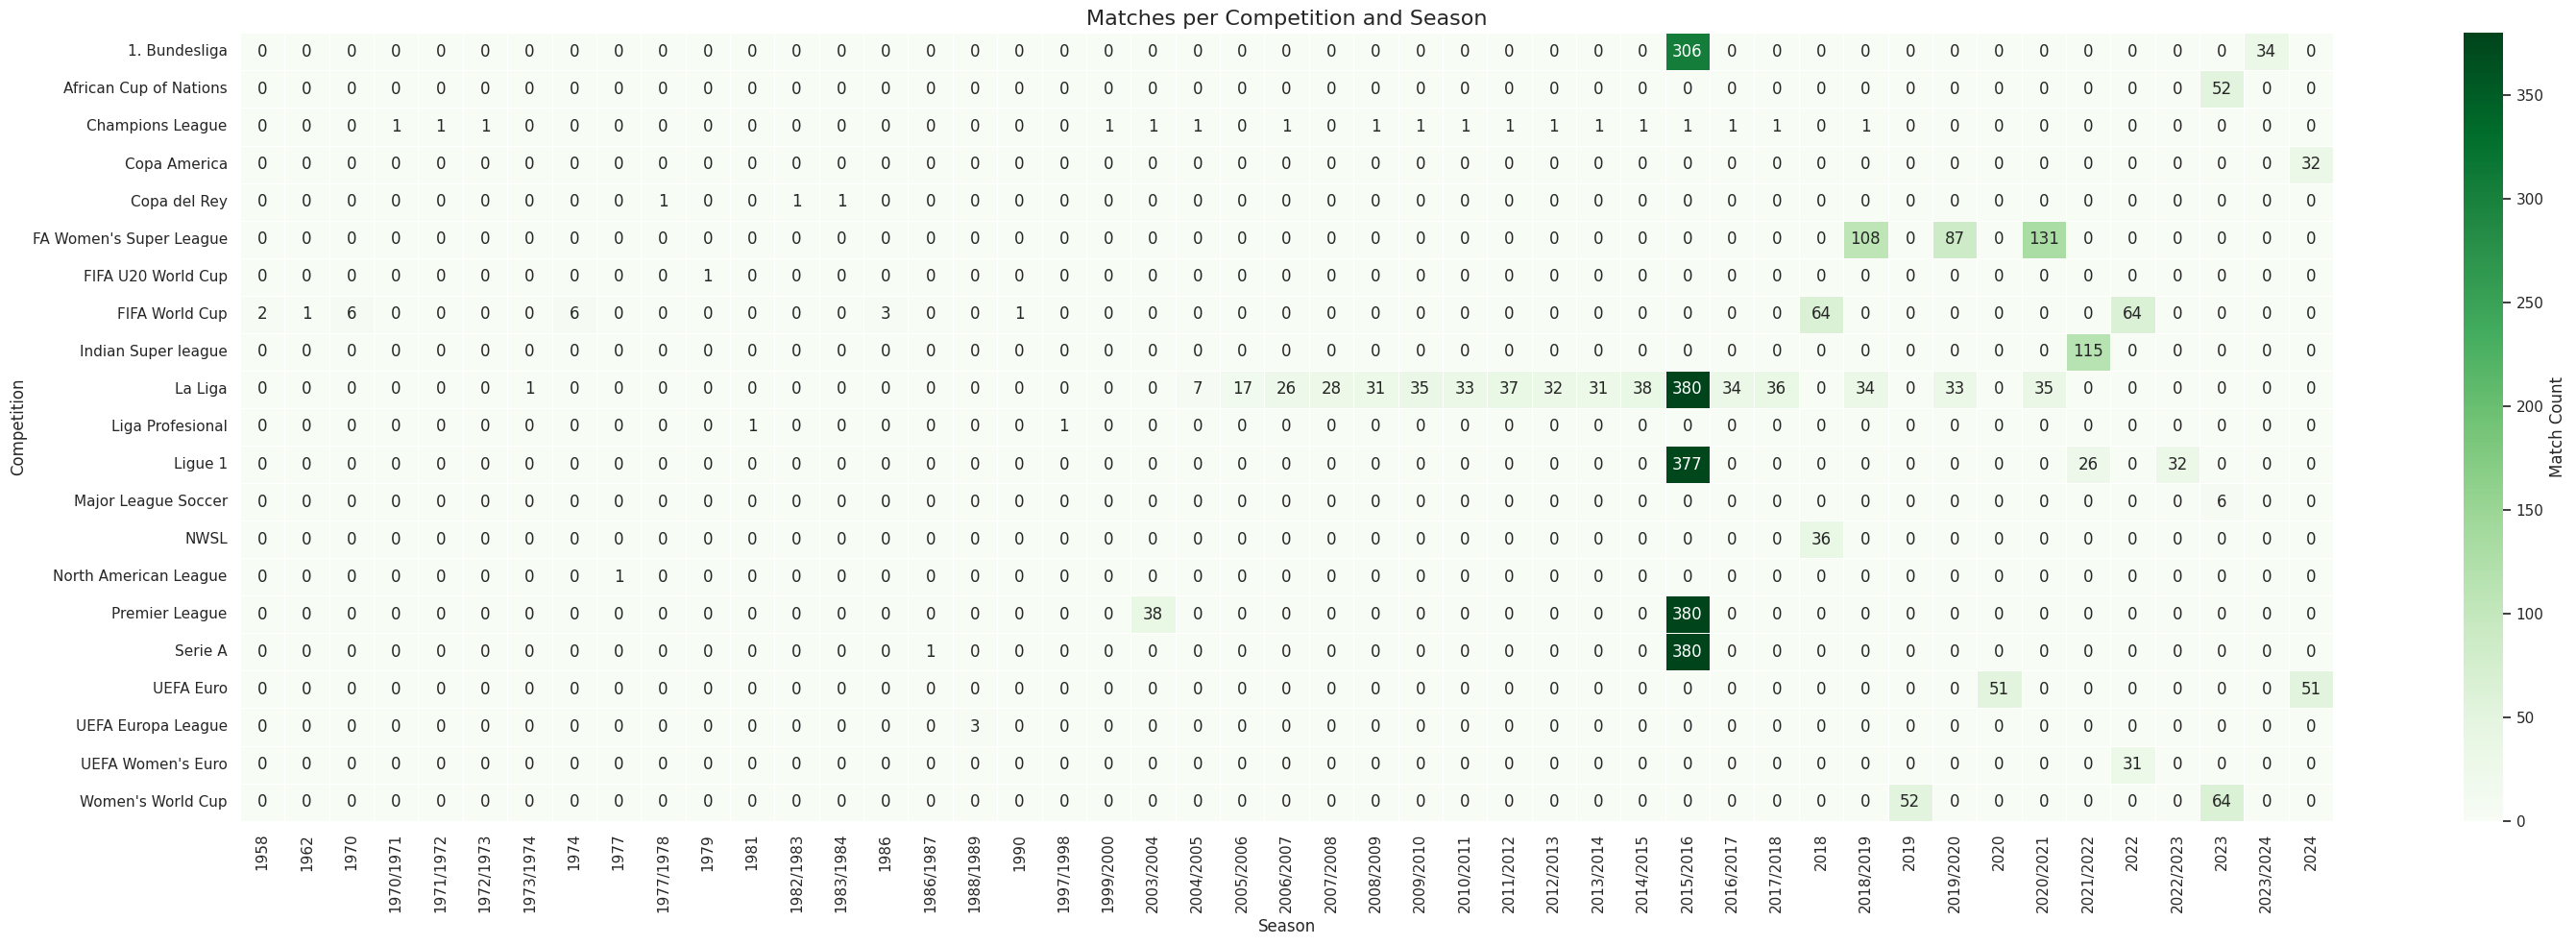

In [18]:
#Data per league can be from different seasons. Therefore a pivot with rows = competition, columns = season and values = match count is created to get a better overview of the available data

pivot = all_matches.pivot_table(
    index='competition_name',
    columns='season_name',
    values='match_id',
    aggfunc='count',
    fill_value=0
)

plt.figure(figsize=(30, 10))
sns.set(font_scale=1.0)

ax = sns.heatmap(pivot,
                 cmap = "Greens",
                 linewidths=0.5,
                 annot=True,
                 fmt='d',
                 cbar_kws={'label': 'Match Count'})

plt.title('Matches per Competition and Season', fontsize=16)
plt.xlabel('Season')
plt.ylabel('Competition')
plt.tight_layout()
plt.show()


In [29]:
#For building an xG model, I am only interested in shoots and their outcome. Therefore, I need to understand how to narrow my dataset down. For that I look into one example match.

#Opta provides data on all matches from Bayer Leverkusens unbeaten 2023/2024 season. Let's look at a match against RB Leipzig.
df_competition[(df_competition['competition_name'] == '1. Bundesliga') & (df_competition['season_name'] == '2023/2024')]

,competition_id,season_id,country_name,competition_name,competition_gender,competition_youth,competition_international,season_name,match_updated,match_updated_360,match_available_360,match_available
0,9,281,Germany,1. Bundesliga,male,False,False,2023/2024,2024-07-15T14:15:54.671676,2024-07-15T14:17:00.877356,2024-07-15T14:17:00.877356,2024-07-15T14:15:54.671676


In [32]:
#Bundesliga competition_id = 9, 2023/2024 season_id = 281
df_match = parser.match(competition_id=9, season_id=281)
df_match.info()

lev_vs_rb_matches_df = df_match[(df_match['home_team_name'] == 'RB Leipzig') | (df_match['away_team_name'] == 'RB Leipzig')]
lev_vs_rb_matches_df.head()

#Both matches ended Leverkusen 3 - 2 Leipzig. Matches are uniquely identified using match_id. Now we look into the the match played in Leipzig.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34 entries, 0 to 33
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   match_id                         34 non-null     int64         
 1   match_date                       34 non-null     datetime64[ns]
 2   kick_off                         34 non-null     datetime64[ns]
 3   home_score                       34 non-null     int64         
 4   away_score                       34 non-null     int64         
 5   match_status                     34 non-null     object        
 6   match_status_360                 34 non-null     object        
 7   last_updated                     34 non-null     datetime64[ns]
 8   last_updated_360                 34 non-null     datetime64[ns]
 9   match_week                       34 non-null     int64         
 10  competition_id                   34 non-null     int64         


,match_id,match_date,kick_off,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,...,competition_stage_id,competition_stage_name,stadium_id,stadium_name,stadium_country_id,stadium_country_name,referee_id,referee_name,referee_country_id,referee_country_name
23,3895202,2024-01-20,2024-01-20 19:30:00,2,3,available,available,2024-02-23 07:15:11.034109,2024-03-24 11:04:42.281656,18,...,1,Regular Season,376,Red Bull Arena,85,Germany,837,Matthias Jöllenbeck,85,Germany
33,3895052,2023-08-19,2023-08-19 16:30:00,3,2,available,available,2023-10-27 17:32:50.230518,2023-11-21 13:34:09.912520,1,...,1,Regular Season,377,BayArena,85,Germany,186,Felix Brych,85,Germany


In [39]:
df_event, df_related, df_freeze, df_tactics = parser.event(3895202)

#The events from the event interface are stored in three dataframes.
#df_event:
#df_related: A dataframe with the Ids of related events. For example, a shot might be related to the Goalkeeper event and a Block Event.The corresponding events will have the Id of the shot in their related_events column.
#df_freeze: Each shot includes an object called freeze_frame which is an array containing information about relevant players at the time of the shot.
#df_tactics: At the beginning of each match, an event is recorded for the tactics and lineups for each team.

df_event.info()
df_related.info()
df_freeze.info()
df_tactics.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4008 entries, 0 to 4007
Data columns (total 70 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              4008 non-null   object 
 1   index                           4008 non-null   int64  
 2   period                          4008 non-null   int64  
 3   timestamp                       4008 non-null   object 
 4   minute                          4008 non-null   int64  
 5   second                          4008 non-null   int64  
 6   possession                      4008 non-null   int64  
 7   duration                        2936 non-null   float64
 8   match_id                        4008 non-null   int64  
 9   type_id                         4008 non-null   int64  
 10  type_name                       4008 non-null   object 
 11  possession_team_id              4008 non-null   int64  
 12  possession_team_name            40

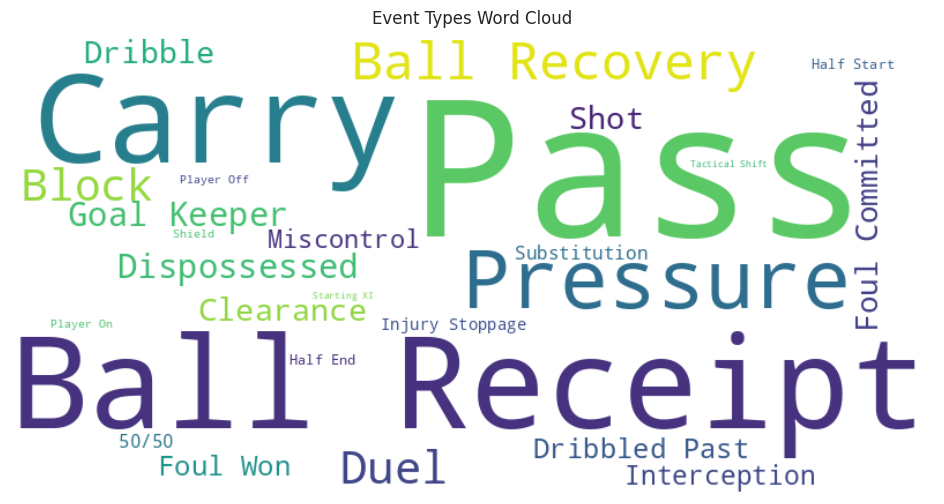

In [56]:
from wordcloud import WordCloud

event_counts = df_event['type_name'].value_counts().to_dict()
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(event_counts)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Event Types Word Cloud')
plt.show()

In [59]:
#There are ~4000 events in this match and over 3000 matches available.
#To create a good foundation for the model training while keeping the dataframe size reasonable I will focus on events with type_name == Shot.

shots_df = df_event[df_event["type_name"] == 'Shot']
len(shots_df)

#Now the dataset was reduced to 28 rows. I want to look at them a bit closer.

28

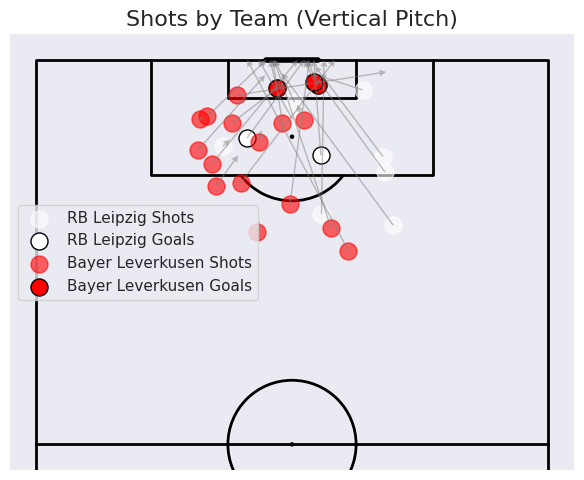

In [68]:
pitch = VerticalPitch(line_color='black', pitch_type='statsbomb', half=True)
fig, ax = pitch.draw(figsize=(6, 10))

team_info = shots_df[['team_id', 'team_name']].drop_duplicates()
team_info_dict = dict(zip(team_info['team_id'].astype(str), team_info['team_name']))

team_colors = {
    '182': 'white',
    '904': 'red'
}

for team_id_str, color in team_colors.items():
    team_name = team_info_dict.get(team_id_str, f'Team {team_id_str}')
    team_shots = shots_df[shots_df['team_id'].astype(str) == team_id_str]

    pitch.scatter(team_shots['x'], team_shots['y'], s=150, c=color, alpha=0.6, label=f'{team_name} Shots', ax=ax)

    team_goals = team_shots[team_shots['outcome_name'] == 'Goal']
    pitch.scatter(team_goals['x'], team_goals['y'], s=150, c=color, edgecolors='black', label=f'{team_name} Goals', ax=ax)

pitch.arrows(shots_df['x'], shots_df['y'], shots_df['end_x'], shots_df['end_y'], width=1, headwidth=5, headlength=5, color='gray', alpha=0.5, ax=ax)

ax.legend()
ax.set_title('Shots by Team (Vertical Pitch)', fontsize=16)
plt.show()

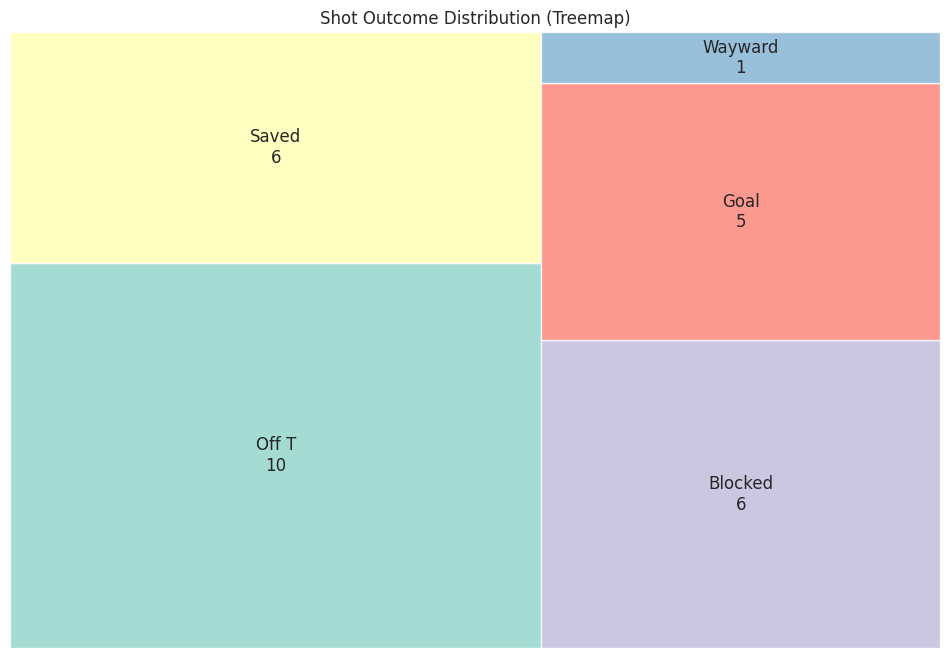

In [76]:
outcome_counts = shots_df['outcome_name'].value_counts()
labels = [f'{label}\n{count}' for label, count in zip(outcome_counts.index, outcome_counts.values)]


plt.figure(figsize=(12, 8))
squarify.plot(sizes=outcome_counts.values, label=labels, alpha=0.8, color=sns.color_palette("Set3", len(outcome_counts)))
plt.axis('off')
plt.title('Shot Outcome Distribution (Treemap)')
plt.show()


In [15]:
df_first_goal_freeze = df_freeze[df_freeze["id"] == 'a425a1dc-0ce2-415e-bf03-55c6b95e794a']
df_first_goal_freeze.info()
df_first_goal_freeze.head(13)

<class 'pandas.core.frame.DataFrame'>
Index: 14 entries, 0 to 13
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   teammate         14 non-null     bool   
 1   match_id         14 non-null     int64  
 2   id               14 non-null     object 
 3   x                14 non-null     float64
 4   y                14 non-null     float64
 5   player_id        14 non-null     int64  
 6   player_name      14 non-null     object 
 7   position_id      14 non-null     int64  
 8   position_name    14 non-null     object 
 9   event_freeze_id  14 non-null     int64  
dtypes: bool(1), float64(2), int64(4), object(3)
memory usage: 1.1+ KB


,teammate,match_id,id,x,y,player_id,player_name,position_id,position_name,event_freeze_id
0,True,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,110.2,38.8,10229,Emma Stina Blackstenius,23,Center Forward,1
1,False,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,94.0,24.7,10180,Ellen White,23,Center Forward,2
2,False,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,100.2,36.4,4641,Francesca Kirby,15,Left Center Midfield,3
3,False,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,101.9,45.3,15619,Bethany Mead,16,Left Midfield,4
4,True,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,107.4,58.1,13881,Eva Sofia Jakobsson,17,Right Wing,5
5,False,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,107.4,18.7,4654,Nikita Parris,12,Right Midfield,6
6,False,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,101.5,27.6,10172,Jill Scott,13,Right Center Midfield,7
7,False,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,107.1,26.0,10178,Lucy Bronze,2,Right Back,8
8,False,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,118.7,42.7,19421,Carly Mitchell Telford,1,Goalkeeper,9
9,False,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,113.1,45.5,10252,Alex Greenwood,6,Left Back,10


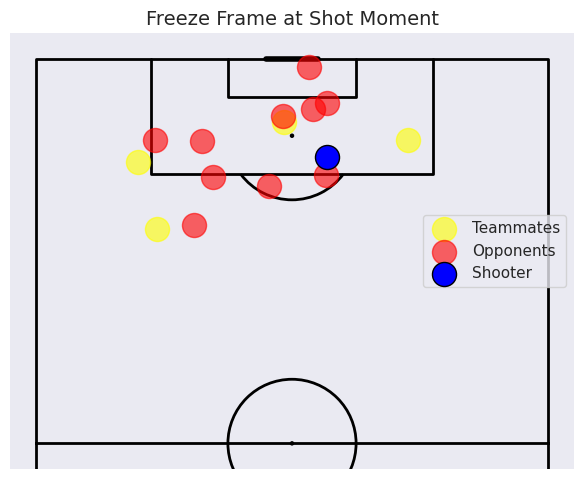

In [18]:
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

pitch = VerticalPitch(pitch_type='statsbomb', half=True, line_color='black')
fig, ax = pitch.draw(figsize=(6, 10))

event_id = 'a425a1dc-0ce2-415e-bf03-55c6b95e794a'
freeze = df_first_goal_freeze

# Separate teammates and opponents
teammates = freeze[freeze['teammate'] == True]
opponents = freeze[freeze['teammate'] == False]

# Plot teammates in blue
pitch.scatter(teammates['x'], teammates['y'], s=300, c='yellow', alpha=0.6, label='Teammates', ax=ax)

# Plot opponents in red
pitch.scatter(opponents['x'], opponents['y'], s=300, c='red', alpha=0.6, label='Opponents', ax=ax)

# Highlight the shooter (assumes shooter is in teammates and has matching event ID)
shooter = shots_df[shots_df['id'] == event_id].iloc[0]
pitch.scatter(shooter['x'], shooter['y'], s=300, c='blue', edgecolors='black', label='Shooter', ax=ax)

# Title and legend
ax.set_title("Freeze Frame at Shot Moment", fontsize=14)
ax.legend(loc='right')
plt.show()


In [19]:
df_related[df_related["id"] == 'a425a1dc-0ce2-415e-bf03-55c6b95e794a']

,match_id,id,index,type_name,id_related,index_related,type_name_related
496,69301,a425a1dc-0ce2-415e-bf03-55c6b95e794a,340,Shot,e2c61b4a-f0eb-44f2-8899-df1778683ee9,341,Goal Keeper


In [20]:
matches_df = parser.match(competition_id=72, season_id=30)

match_ids = matches_df['match_id'].tolist()

shot_fields = [
    'id',
    'period',
    'timestamp',
    'play_pattern_id',
    'play_pattern_name',
    'team_id',
    'team_name',
    'player_id',
    'player_name',
    'body_part_id',
    'body_part_name',
    'shot_key_pass_id',
    'x',
    'y',
    'end_x',
    'end_y',
    'end_z',
    'aerial_won',
    'shot_first_time',
    'shot_statsbomb_xg',
    'block_deflection',
    'technique_id',
    'technique_name',
    'body_part_id',
    'body_part_name',
    'sub_type_id',
    'sub_type_name',
    'outcome_id',
    'outcome_name'
]

all_shots = []

for match_id in match_ids:
    df_event, df_related, df_freeze, df_tactics = parser.event(match_id)


    df_shots = df_event[df_event['type_name'] == 'Shot']

    for col in shot_fields:
        if col not in df_shots.columns:
            df_shots[col] = None

    # Keep only the desired fields
    df_shots_clean = df_shots[shot_fields].copy()
    df_shots_clean['match_id'] = match_id

    all_shots.append(df_shots_clean)

shots_master_women_world_cup_df = pd.concat(all_shots, ignore_index=True)


In [21]:
shots_master_women_world_cup_df.info()
shots_master_women_world_cup_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 30 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1314 non-null   object 
 1   period             1314 non-null   int64  
 2   timestamp          1314 non-null   object 
 3   play_pattern_id    1314 non-null   int64  
 4   play_pattern_name  1314 non-null   object 
 5   team_id            1314 non-null   int64  
 6   team_name          1314 non-null   object 
 7   player_id          1314 non-null   float64
 8   player_name        1314 non-null   object 
 9   body_part_id       1314 non-null   float64
 10  body_part_name     1314 non-null   object 
 11  shot_key_pass_id   925 non-null    object 
 12  x                  1314 non-null   float64
 13  y                  1314 non-null   float64
 14  end_x              1314 non-null   float64
 15  end_y              1314 non-null   float64
 16  end_z              919 n

,id,period,timestamp,play_pattern_id,play_pattern_name,team_id,team_name,player_id,player_name,body_part_id,...,block_deflection,technique_id,technique_name,body_part_id,body_part_name,sub_type_id,sub_type_name,outcome_id,outcome_name,match_id
0,61ba8fdd-7b2e-4967-8c3c-038cad3d44c1,1,00:01:45.395000,3,From Free Kick,857,Germany Women's,10263.0,Sara Däbritz,38.0,...,NaN,93.0,Normal,38.0,Left Foot,62.0,Free Kick,96.0,Blocked,22949
1,3473cc2a-c7b4-4c21-b4c5-3631b79d8ba8,1,00:13:55.191000,4,From Throw In,863,Spain Women's,25510.0,Nahikari García Pérez,40.0,...,NaN,93.0,Normal,40.0,Right Foot,87.0,Open Play,98.0,Off T,22949
2,b987d5a3-0152-4919-8fcf-5ad26f4b2883,1,00:15:47.927000,4,From Throw In,863,Spain Women's,10153.0,Silvia Meseguer Bellido,40.0,...,NaN,93.0,Normal,40.0,Right Foot,87.0,Open Play,98.0,Off T,22949
3,cd838028-9847-4638-86d6-955feb6ec3e0,1,00:16:44.355000,1,Regular Play,857,Germany Women's,25492.0,Giulia Gwinn,40.0,...,NaN,93.0,Normal,40.0,Right Foot,87.0,Open Play,100.0,Saved,22949
4,7d9bced3-546a-4116-aded-67eeed94a1f5,1,00:17:46.017000,1,Regular Play,857,Germany Women's,25492.0,Giulia Gwinn,40.0,...,NaN,93.0,Normal,40.0,Right Foot,87.0,Open Play,98.0,Off T,22949


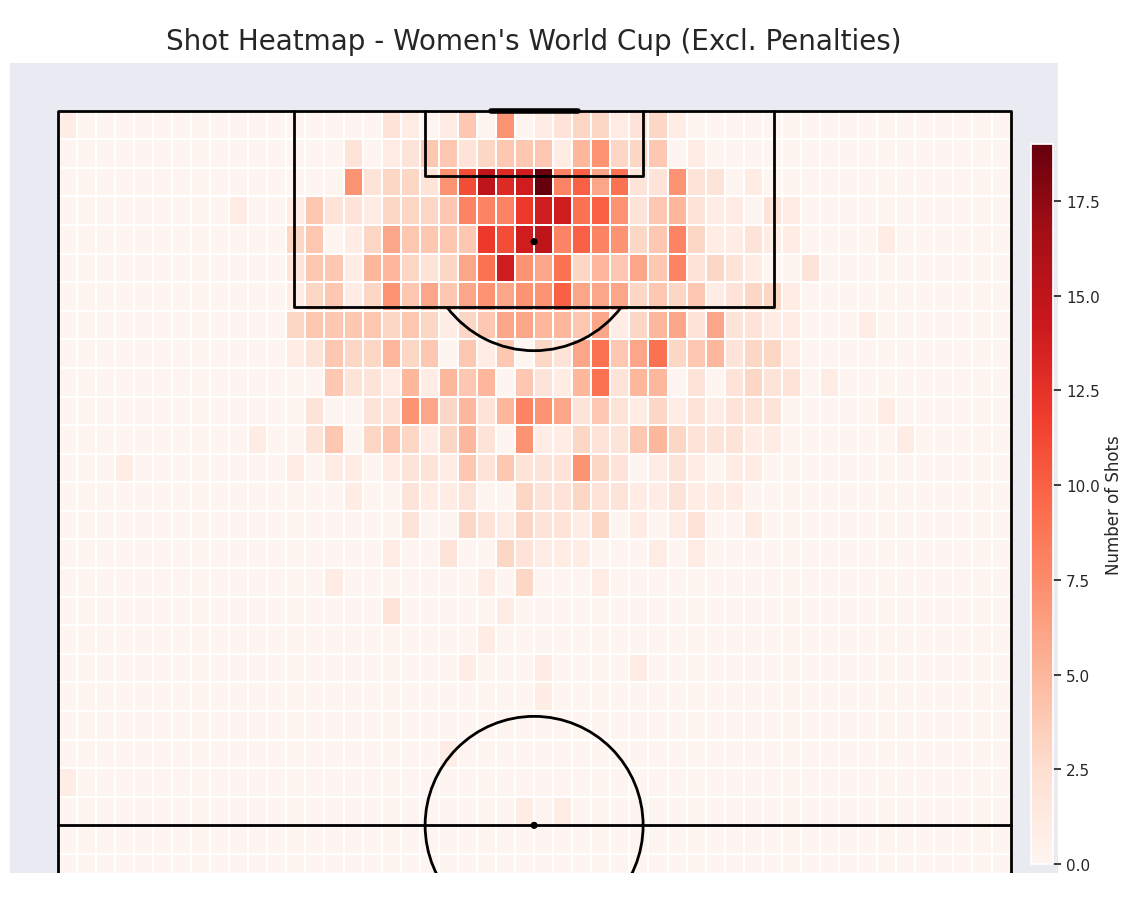

In [22]:
# Filter out penalties
shots_no_penalties = shots_master_women_world_cup_df[shots_master_women_world_cup_df['sub_type_name'] != 'Penalty']

# Set up the pitch
pitch = VerticalPitch(
    line_color='black',
    half=True,
    pitch_type='custom',
    pitch_length=120,
    pitch_width=80,
    line_zorder=2
)

fig, ax = pitch.grid(
    grid_height=0.9,
    title_height=0.06,
    axis=False,
    endnote_height=0.04,
    title_space=0,
    endnote_space=0
)

# Calculate bin statistics without penalties
bin_statistic_shots = pitch.bin_statistic(
    shots_no_penalties['x'],
    shots_no_penalties['y'],
    bins=(50, 50)
)

# Plot heatmap
pcm = pitch.heatmap(
    bin_statistic_shots,
    ax=ax['pitch'],
    cmap='Reds',
    edgecolor='white',
    linewidth=0.01
)

# Colorbar
ax_cbar = fig.add_axes((0.95, 0.05, 0.02, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
cbar.set_label('Number of Shots')

# Title
fig.suptitle('Shot Heatmap - Women\'s World Cup (Excl. Penalties)', fontsize=20)
plt.show()


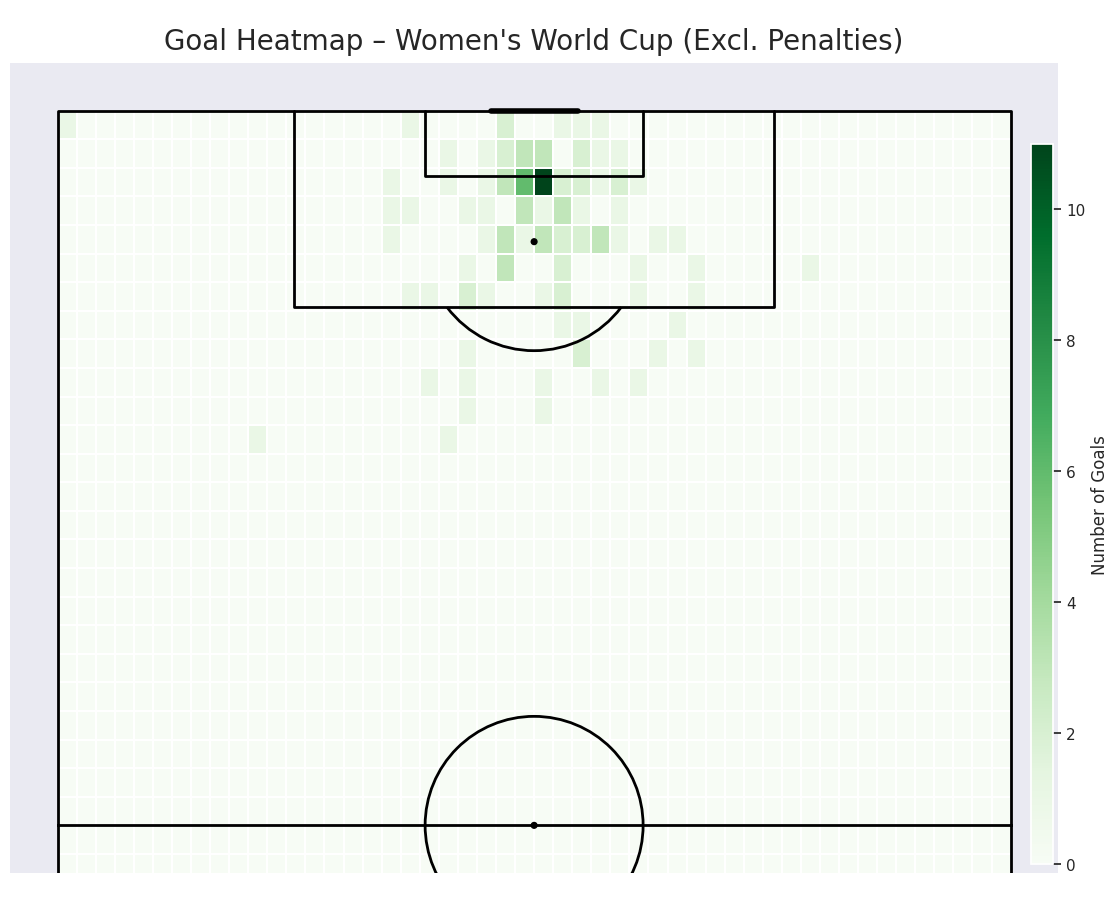

In [23]:
non_penalty_shots = shots_master_women_world_cup_df[shots_master_women_world_cup_df['sub_type_name'] != 'Penalty']

goals = non_penalty_shots[non_penalty_shots['outcome_name'] == 'Goal']

from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

# Set up pitch
pitch = VerticalPitch(
    line_color='black',
    half=True,
    pitch_type='custom',
    pitch_length=120,
    pitch_width=80,
    line_zorder=2
)

fig, ax = pitch.grid(
    grid_height=0.9,
    title_height=0.06,
    axis=False,
    endnote_height=0.04,
    title_space=0,
    endnote_space=0
)

# Compute bin stats for goals only
bin_statistic_goals = pitch.bin_statistic(
    goals['x'],
    goals['y'],
    bins=(50, 50)
)

# Heatmap
pcm = pitch.heatmap(
    bin_statistic_goals,
    ax=ax['pitch'],
    cmap='Greens',
    edgecolor='white',
    linewidth=0.01
)

# Colorbar
ax_cbar = fig.add_axes((0.95, 0.05, 0.02, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
cbar.set_label('Number of Goals')

# Title
fig.suptitle('Goal Heatmap – Women\'s World Cup (Excl. Penalties)', fontsize=20)
plt.show()



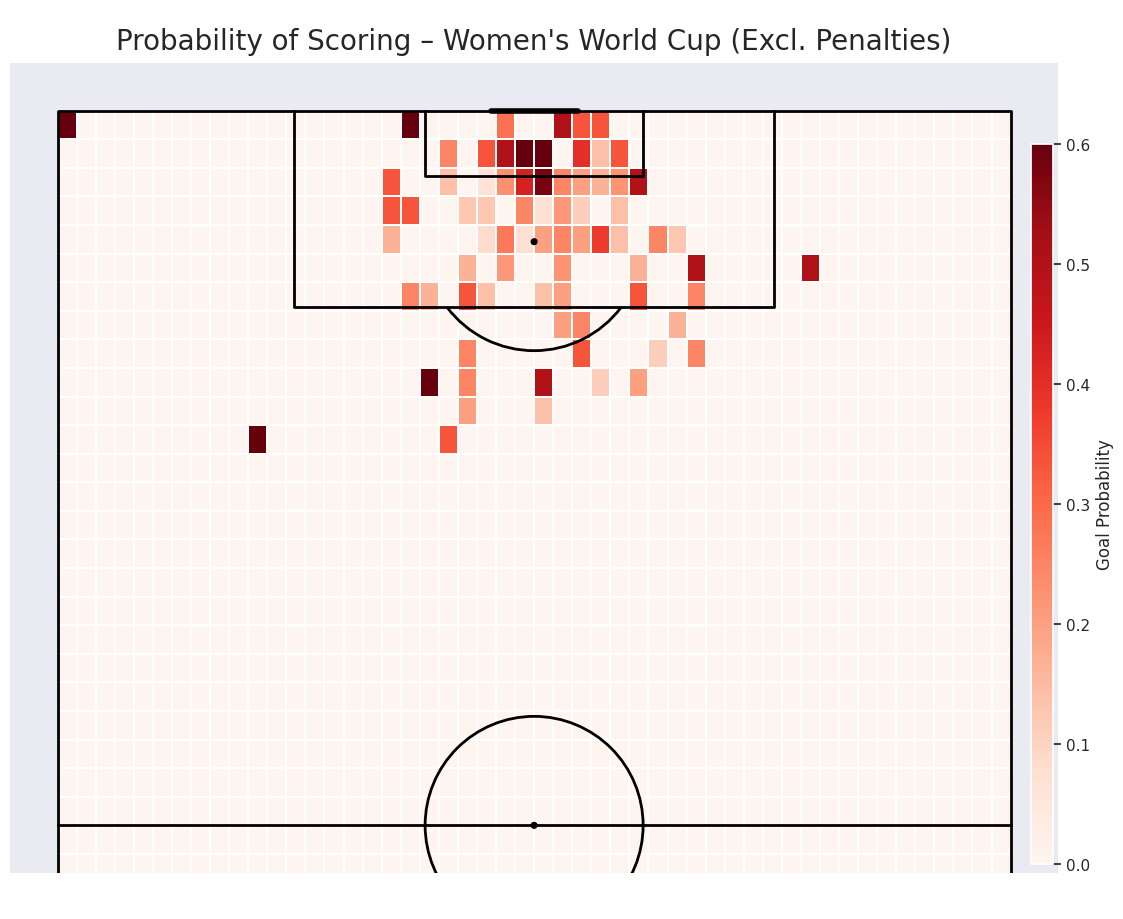

In [24]:
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

# 1. Filter out penalties
non_penalty_shots = shots_master_women_world_cup_df[shots_master_women_world_cup_df['sub_type_name'] != 'Penalty']

# 2. Separate all shots and goals
shots = non_penalty_shots
goals = shots[shots['outcome_name'] == 'Goal']

# 3. Create the pitch
pitch = VerticalPitch(
    line_color='black',
    half=True,
    pitch_type='custom',
    pitch_length=120,  # adjust if your x values go to 120
    pitch_width=80,    # adjust if your y values go to 80
    line_zorder=2
)

fig, ax = pitch.grid(
    grid_height=0.9,
    title_height=0.06,
    axis=False,
    endnote_height=0.04,
    title_space=0,
    endnote_space=0
)

# 4. Bin stats
bin_shots = pitch.bin_statistic(shots['x'], shots['y'], bins=(50, 50))
bin_goals = pitch.bin_statistic(goals['x'], goals['y'], bins=(50, 50))

# 5. Calculate goal probability (clip to avoid division by zero)
goal_probability = bin_goals['statistic'] / bin_shots['statistic']
goal_probability = np.nan_to_num(goal_probability, nan=0.0, posinf=0.0, neginf=0.0)
bin_shots['statistic'] = goal_probability

# 6. Plot heatmap
pcm = pitch.heatmap(
    bin_shots,
    ax=ax['pitch'],
    cmap='Reds',
    edgecolor='white',
    vmin=0,
    vmax=0.6,
    linewidth=0.01
)

# 7. Colorbar
ax_cbar = fig.add_axes((0.95, 0.05, 0.02, 0.8))
cbar = plt.colorbar(pcm, cax=ax_cbar)
cbar.set_label('Goal Probability')

# 8. Title
fig.suptitle('Probability of Scoring – Women\'s World Cup (Excl. Penalties)', fontsize=20)
plt.show()


In [86]:
import numpy as np

shots_master_women_world_cup_df['distance_to_goal'] = np.sqrt(
    (GOAL_X - shots_master_women_world_cup_df['x'])**2 +
    (GOAL_CENTER_Y - shots_master_women_world_cup_df['y'])**2
)

In [99]:
import numpy as np

# Constants
GOAL_WIDTH = 7.32  # meters
GOAL_CENTER_X = 120
GOAL_CENTER_Y = 40

In [100]:
distance_to_goal = np.sqrt((GOAL_CENTER_X - x)**2 + (GOAL_CENTER_Y - y)**2)
shots_master_women_world_cup_df['distance_to_goal'] = distance_to_goal

In [101]:
# Goalpost y-coordinates
goal_y1 = GOAL_CENTER_Y - GOAL_WIDTH / 2  # left post
goal_y2 = GOAL_CENTER_Y + GOAL_WIDTH / 2  # right post

# Shot coordinates
x = shots_master_women_world_cup_df['x'].to_numpy()
y = shots_master_women_world_cup_df['y'].to_numpy()

# Distances from shot to left and right goalposts
a = np.sqrt((GOAL_CENTER_X - x)**2 + (goal_y1 - y)**2)
b = np.sqrt((GOAL_CENTER_X - x)**2 + (goal_y2 - y)**2)
c = GOAL_WIDTH

# Avoid divide-by-zero
denominator = 2 * a * b
cos_angle = (a**2 + b**2 - c**2) / denominator
cos_angle = np.clip(cos_angle, -1.0, 1.0)  # Ensure within valid arccos range

# Calculate angle in radians
angle_radians = np.arccos(cos_angle)

# Store in DataFrame
shots_master_women_world_cup_df['angle_to_goal'] = angle_radians
shots_master_women_world_cup_df['angle_to_goal_deg'] = np.degrees(angle_radians)


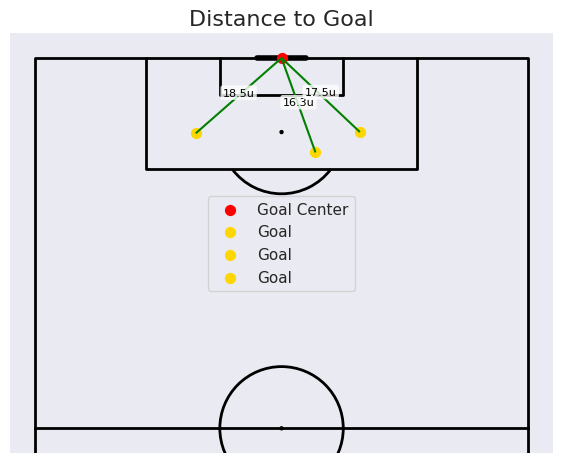

In [103]:
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

test_plot = shots_master_women_world_cup_df[['id','period', 'timestamp', 'team_id', 'team_name', 'player_id', 'player_name', 'x', 'y', 'distance_to_goal', 'angle_to_goal', 'angle_to_goal_deg', 'match_id', 'outcome_name']]

goals_df = test_plot[
    (test_plot['match_id'] == 69301) &
    (test_plot['outcome_name'] == 'Goal')
]


##############################

goal_x = 120
goal_y = 40

# Create the pitch
pitch = VerticalPitch(pitch_type='statsbomb', line_color='black', half = True)
fig, ax = pitch.draw(
    #figsize=(6, 10)
    )

pitch.scatter(goal_x, goal_y, s=50, c='red', ax=ax, label='Goal Center')

for _, row in goals_df.iterrows():
    shot_x = row['x']
    shot_y = row['y']
    distance = row['distance_to_goal']

    # Shot location
    pitch.scatter(shot_x, shot_y, ax=ax, c='gold', s=50, label='Goal')

    # Line to goal center
    pitch.lines(shot_x, shot_y, goal_x, goal_y, ax=ax, color='green', lw=1.5)

    mid_x = (shot_x + goal_x) / 2
    mid_y = (shot_y + goal_y) / 2
    pitch.annotate(
      f"{distance:.1f}u",
      xy=(mid_x, mid_y),
      ax=ax,
      fontsize=8,
      ha='center',
      color='black',
      bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round', pad=0.2)
    )



# Title and legend
ax.set_title('Distance to Goal', fontsize=16)
ax.legend()
plt.show()

In [93]:
goal_width = 7.32
left_post_y = goal_y - goal_width / 2
right_post_y = goal_y + goal_width / 2

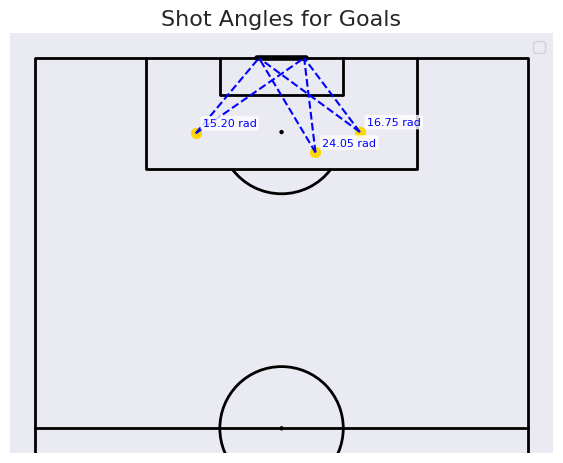

In [95]:
from mplsoccer import VerticalPitch
import matplotlib.pyplot as plt

goal_x, goal_y = 120, 40
goal_width = 7.32
left_post_y = goal_y - goal_width / 2
right_post_y = goal_y + goal_width / 2

pitch = VerticalPitch(pitch_type='statsbomb', line_color='black', half=True)
fig, ax = pitch.draw()

for i, row in goals_df.iterrows():
    shot_x = row['x']
    shot_y = row['y']
    angle = row['angle_to_goal_deg']

    pitch.scatter(shot_x, shot_y, ax=ax, c='gold', s=50, label='Goal' if i == 0 else None)

    pitch.lines(shot_x, shot_y, goal_x, left_post_y, ax=ax, color='blue', lw=1.5, linestyle='--')
    pitch.lines(shot_x, shot_y, goal_x, right_post_y, ax=ax, color='blue', lw=1.5, linestyle='--')

    pitch.annotate(
        f"{angle:.2f} rad",
        xy=(shot_x, shot_y),
        ax=ax,
        fontsize=8,
        ha='left',
        color='blue',
        xytext=(5, 5),
        textcoords='offset points',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round' ,pad=0.2)
    )

ax.set_title('Shot Angles for Goals', fontsize=16)
ax.legend()
plt.show()

In [107]:
shots_master_women_world_cup_df.info()
shots_master_women_world_cup_df.head(50)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1314 entries, 0 to 1313
Data columns (total 33 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1314 non-null   object 
 1   period             1314 non-null   int64  
 2   timestamp          1314 non-null   object 
 3   play_pattern_id    1314 non-null   int64  
 4   play_pattern_name  1314 non-null   object 
 5   team_id            1314 non-null   int64  
 6   team_name          1314 non-null   object 
 7   player_id          1314 non-null   float64
 8   player_name        1314 non-null   object 
 9   body_part_id       1314 non-null   float64
 10  body_part_name     1314 non-null   object 
 11  shot_key_pass_id   925 non-null    object 
 12  x                  1314 non-null   float64
 13  y                  1314 non-null   float64
 14  end_x              1314 non-null   float64
 15  end_y              1314 non-null   float64
 16  end_z              919 n

,id,period,timestamp,play_pattern_id,play_pattern_name,team_id,team_name,player_id,player_name,body_part_id,...,body_part_id,body_part_name,sub_type_id,sub_type_name,outcome_id,outcome_name,match_id,distance_to_goal,angle_to_goal,angle_to_goal_deg
0,61ba8fdd-7b2e-4967-8c3c-038cad3d44c1,1,00:01:45.395000,3,From Free Kick,857,Germany Women's,10263.0,Sara Däbritz,38.0,...,38.0,Left Foot,62.0,Free Kick,96.0,Blocked,22949,34.972132,0.187189,10.725125
1,3473cc2a-c7b4-4c21-b4c5-3631b79d8ba8,1,00:13:55.191000,4,From Throw In,863,Spain Women's,25510.0,Nahikari García Pérez,40.0,...,40.0,Right Foot,87.0,Open Play,98.0,Off T,22949,16.667633,0.430768,24.681211
2,b987d5a3-0152-4919-8fcf-5ad26f4b2883,1,00:15:47.927000,4,From Throw In,863,Spain Women's,10153.0,Silvia Meseguer Bellido,40.0,...,40.0,Right Foot,87.0,Open Play,98.0,Off T,22949,19.158810,0.376469,21.570073
3,cd838028-9847-4638-86d6-955feb6ec3e0,1,00:16:44.355000,1,Regular Play,857,Germany Women's,25492.0,Giulia Gwinn,40.0,...,40.0,Right Foot,87.0,Open Play,100.0,Saved,22949,17.057843,0.179993,10.312824
4,7d9bced3-546a-4116-aded-67eeed94a1f5,1,00:17:46.017000,1,Regular Play,857,Germany Women's,25492.0,Giulia Gwinn,40.0,...,40.0,Right Foot,87.0,Open Play,98.0,Off T,22949,35.202415,0.198014,11.345394
5,6b0f45c7-2429-49d7-979f-9e9f602df355,1,00:20:58.132000,4,From Throw In,863,Spain Women's,10202.0,Virginia Torrecilla Reyes,40.0,...,40.0,Right Foot,87.0,Open Play,96.0,Blocked,22949,30.923292,0.235448,13.490156
6,adcd0aef-ee8d-4e75-85f2-5c9044b87220,1,00:21:42.894000,4,From Throw In,863,Spain Women's,10200.0,Marta Corredera Rueda,40.0,...,40.0,Right Foot,87.0,Open Play,100.0,Saved,22949,32.444568,0.081524,4.670961
7,6e7f8020-b449-4635-b528-683609385707,1,00:31:10.023000,4,From Throw In,857,Germany Women's,10374.0,Svenja Huth,40.0,...,40.0,Right Foot,87.0,Open Play,100.0,Saved,22949,20.700242,0.216957,12.430724
8,92e7c280-b29a-480a-968d-4d4d4334b9f8,1,00:32:20.402000,2,From Corner,863,Spain Women's,10151.0,Jennifer Hermoso Fuentes,38.0,...,38.0,Left Foot,87.0,Open Play,96.0,Blocked,22949,13.018833,0.252420,14.462576
9,c7428f15-43a1-4cb3-97bf-cec751fce47e,1,00:32:48.689000,2,From Corner,863,Spain Women's,10153.0,Silvia Meseguer Bellido,38.0,...,38.0,Left Foot,87.0,Open Play,96.0,Blocked,22949,28.624640,0.248169,14.219048


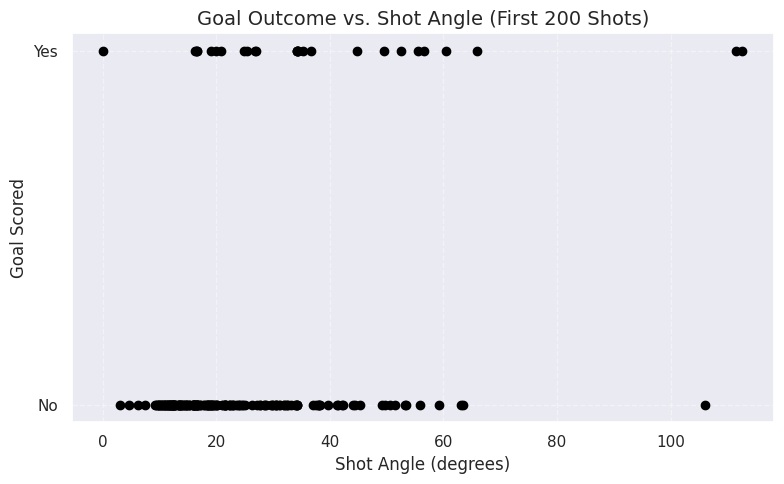

In [114]:
shots_master_women_world_cup_df['goal'] = (shots_master_women_world_cup_df['outcome_name'] == 'Goal').astype(int)

shots_200 = shots_master_women_world_cup_df.iloc[:200]

fig, ax = plt.subplots(figsize=(8, 5))
ax.plot(
    shots_200['angle_to_goal_deg'],
    shots_200['goal'],
    linestyle='none',
    marker='.',
    markersize=12,
    color='black'
)

# Axis labels and formatting
ax.set_ylabel('Goal Scored', fontsize=12)
ax.set_xlabel('Shot Angle (degrees)', fontsize=12)
ax.set_yticks([0, 1])
ax.set_yticklabels(['No', 'Yes'])
plt.ylim(-0.05, 1.05)
ax.set_title('Goal Outcome vs. Shot Angle (First 200 Shots)', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()



build database

In [122]:
# Step 1: Get all available competitions
competitions_df = parser.competition()

# Step 2: Prepare storage
all_shots = []

# Step 3: Define your desired shot fields
shot_fields = [
    'id',
    'team_id',
    'team_name',
    'shot_key_pass_id',
    'x',
    'y',
    'end_x',
    'end_y',
    'end_z',
    'aerial_won',
    'shot_first_time',
    'shot_statsbomb_xg',
    'block_deflection',
    'technique_id',
    'technique_name',
    'body_part_id',
    'body_part_name',
    'sub_type_id',
    'sub_type_name',
    'outcome_id',
    'outcome_name'
]

# Step 4: Loop through competitions and matches
for _, comp_row in competitions_df.iterrows():
    comp_id = comp_row['competition_id']
    season_id = comp_row['season_id']

    try:
        matches_df = parser.match(competition_id=comp_id, season_id=season_id)
    except Exception as e:
        print(f"Skipping competition {comp_id}-{season_id} due to error: {e}")
        continue

    for match_id in matches_df['match_id']:
        try:
            df_event, df_related, df_freeze, df_tactics = parser.event(match_id)
            df_shots = df_event[df_event['type_name'] == 'Shot']

            for col in shot_fields:
                if col not in df_shots.columns:
                    df_shots[col] = None

            df_shots_clean = df_shots[shot_fields].copy()
            df_shots_clean['match_id'] = match_id
            df_shots_clean['competition_id'] = comp_id
            df_shots_clean['season_id'] = season_id

            all_shots.append(df_shots_clean)

        except Exception as e:
            print(f"Error processing match {match_id}: {e}")
            continue


shots_master_df = pd.concat(all_shots, ignore_index=True)


KeyboardInterrupt: 

fit model

In [115]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import numpy as np

In [133]:
X = shots_master_women_world_cup_df[['angle_to_goal_deg', 'distance_to_goal', 'x', 'y']]


    #'body_part_id',
    #'body_part_name',
    #'shot_key_pass_id',
    #'x',
    #'y',
    #'end_x',
    #'end_y',
    #'end_z',
    #'aerial_won',
    #'shot_first_time',
    #'shot_statsbomb_xg',
    #'block_deflection',
    #'technique_id',
    #'technique_name',
    #'body_part_id',
    #'body_part_name',
    #'sub_type_id',
    #'sub_type_name',

y = shots_master_women_world_cup_df['goal']

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [135]:
model = LogisticRegression()
model.fit(X_train, y_train)


LogisticRegression()

In [136]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:, 1]  # probabilities

print(classification_report(y_test, y_pred))
print("ROC AUC:", roc_auc_score(y_test, y_prob))


              precision    recall  f1-score   support

           0       0.93      0.99      0.96       244
           1       0.50      0.11      0.17        19

    accuracy                           0.93       263
   macro avg       0.72      0.55      0.57       263
weighted avg       0.90      0.93      0.91       263

ROC AUC: 0.8782355478861086


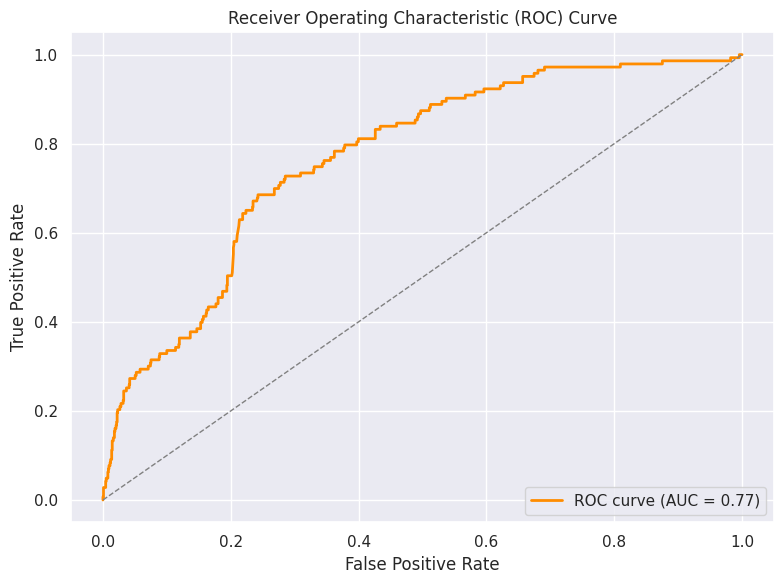

In [137]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Probability of class = 1 (goal)
y_probs = model.predict_proba(X)[:, 1]

fpr, tpr, thresholds = roc_curve(y, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--')  # Diagonal line
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.tight_layout()
plt.show()



In [127]:
import statsmodels.api as sm

# Define your features and target
X = shots_master_women_world_cup_df[['angle_to_goal', 'distance_to_goal']]
y = shots_master_women_world_cup_df['goal']

# Add intercept
X_with_const = sm.add_constant(X)

# Fit logistic regression
model = sm.Logit(y, X_with_const)
result = model.fit()

# Calculate McFadden's R²
ll_model = result.llf               # Log-likelihood of fitted model
ll_null = result.llnull             # Log-likelihood of null model

mcfadden_r2 = 1 - (ll_model / ll_null)
print(f"McFadden's R²: {mcfadden_r2:.4f}")


Optimization terminated successfully.
         Current function value: 0.298084
         Iterations 7
McFadden's R²: 0.1336
